In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import metrics
from skopt import dump, load
from skopt.plots import plot_convergence
from scipy.stats import reciprocal
import skopt
from skopt import gp_minimize
import numpy as np
import pandas as pd
from sklearn import metrics
import datetime
import re
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Load Data from Sources

In [2]:
df = pd.read_excel('mlb_team_batting_wp.xlsx')

In [3]:
df.columns

Index(['Season', 'Team', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI',
       'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'SB', 'CS', 'AVG', 'W', 'L',
       'win_per'],
      dtype='object')

In [4]:
df.shape

(1468, 23)

# Data Pre-Processing

The target for this model will be predicting winning percentage using offensive statistics provided by pybaseball. The following pre-processings must be done:
- Remove wins and loss column, this is part of the prediction
- Remove the average column, batting average is an aggregate statistic and I want to focus on continous values
- Removing hits (H) as it is the sum of the different types of hits
- Remove runs category, I want to focus on other statistics as Runs is known to be an indicator of wins
- Remove RBI for the same reason

In [5]:
mlb_df = df.drop(labels=['Season', 'Team', 'H', 'R', 'RBI', 'AVG', 'W', 'L', 'AB'], axis=1)
mlb_df.columns

Index(['PA', '1B', '2B', '3B', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH',
       'SB', 'CS', 'win_per'],
      dtype='object')

In [6]:
mlb_df.shape

(1468, 14)

### Normalizing Input Vector

Since the values range widely, apply a scaler function to the input vector. Output vector can remain the same as it will always be a value between 0 and 1

In [7]:
x = mlb_df[['PA', '1B', '2B', '3B', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'SB', 'CS']].to_numpy()
y = mlb_df[['win_per']].to_numpy()

In [8]:
y = np.array([ x[0] for x in y ])

In [9]:
x_scaler = MinMaxScaler().fit(x)
x_scaled = x_scaler.transform(x)

In [10]:
# Split last 25% of data for test data
split_val = int(x.shape[0] * .75)
x_train_full, x_test = x_scaled[:split_val], x_scaled[split_val:]
y_train_full, y_test = y[:split_val], y[split_val:]

# Simple Model Build

In [11]:
sm_model = SVR()
sm_model.fit(x_train_full, y_train_full)

SVR()

In [12]:
sm_predicted = sm_model.predict(x_test)
mean_squared_error(sm_predicted, y_test)

0.00610034536038286

# Impact of Initialization

In this section I will explore the effects of Kernel Functions, C values, and degree on the SVM's completetion time and average MSE

## Testing Kernels

In [13]:
def run_kernel_test():
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    test_results = []
    for k in kernels:
        test_mse = []
        test_time = []
        cv = KFold(10)
        for tr_i, ts_i in cv.split(x_scaled, y):
            x_tr, x_val = x_scaled[tr_i], x_scaled[ts_i]
            y_tr, y_val = y[tr_i], y[ts_i]
            test_model = SVR(kernel=k)
            start = time.time()
            test_model.fit(x_tr, y_tr)
            end = time.time()
            
            test_mse.append(mean_squared_error(y_val, test_model.predict(x_val)))
            test_time.append(end - start)
            
        avg_test_mse, avg_test_time = np.mean(test_mse), np.mean(test_time)
        test_results.append(([k for x in range(10)], test_mse, test_time))
        print(f'{k} :: {avg_test_mse} {avg_test_time}')
    return test_results

In [14]:
kernel_test_results = run_kernel_test()

linear :: 0.0033159228179048886 0.02235279083251953
rbf :: 0.003677012960655205 0.0234804630279541
poly :: 0.004053150057685783 0.21232619285583496
sigmoid :: 28.93512836554708 0.10972888469696045


### Build Graphs for this Section

In [15]:
temp = [ list(zip(x[0], x[1], x[2])) for x in kernel_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['kernel', 'mse', 'time'])

In [16]:
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.5)

In [17]:
# kernel_mse_plot = sns.boxplot(x='kernel', y='mse', data=init_test_df)
# kernel_mse_plot.set(ylim=(0, 10), title='Effects on MSE from Kernel')
# kernel_mse_plot.figure.savefig('svm/mlb/graphs/mlbwp_kernel_mse.png')

In [18]:
# kernel_time_plot = sns.boxplot(x='kernel', y='time', data=init_test_df)
# kernel_time_plot.set(title='Effects on Time from Kernel')
# kernel_time_plot.figure.savefig('svm/mlb/graphs/mlbwp_kernel_time.png')

## Testing C

In [19]:
def run_c_test():
    cs = [.1, 1, 10, 100, 1000]
    test_results = []
    for c in cs:
        test_mse = []
        test_time = []
        cv = KFold(10)
        for tr_i, ts_i in cv.split(x_scaled, y):
            x_tr, x_val = x_scaled[tr_i], x_scaled[ts_i]
            y_tr, y_val = y[tr_i], y[ts_i]
            test_model = SVR(C=c)
            start = time.time()
            test_model.fit(x_tr, y_tr)
            end = time.time()
            
            test_mse.append(mean_squared_error(y_val, test_model.predict(x_val)))
            test_time.append(end - start)
            
        avg_test_mse, avg_test_time = np.mean(test_mse), np.mean(test_time)
        test_results.append(([c for x in range(10)], test_mse, test_time))
        print(f'{c} :: {avg_test_mse} {avg_test_time}')
    return test_results

In [20]:
c_test_results = run_c_test()

0.1 :: 0.003540294156939587 0.008766555786132812
1 :: 0.003677012960655205 0.02438836097717285
10 :: 0.0037668170050264667 0.033754277229309085
100 :: 0.0037668170050264667 0.030246424674987792
1000 :: 0.0037668170050264667 0.02921881675720215


### Building Graphs

In [21]:
temp = [ list(zip(x[0], x[1], x[2])) for x in c_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['c', 'mse', 'time'])

In [22]:
# c_mse_plot = sns.boxplot(x='c', y='mse', data=init_test_df)
# c_mse_plot.set(title='Effects on MSE from C')
# c_mse_plot.figure.savefig('svm/mlb/graphs/mlbwp_c_mse.png')

In [23]:
# c_mse_plot = sns.boxplot(x='c', y='time', data=init_test_df)
# c_mse_plot.set(title='Effects on Time from C')
# c_mse_plot.figure.savefig('svm/mlb/graphs/mlbwp_c_time.png')

## Testing Degree

In [24]:
def run_degree_test():
    cs = [2, 3, 4, 5, 6]
    test_results = []
    for c in cs:
        test_mse = []
        test_time = []
        cv = KFold(10)
        for tr_i, ts_i in cv.split(x_scaled, y):
            x_tr, x_val = x_scaled[tr_i], x_scaled[ts_i]
            y_tr, y_val = y[tr_i], y[ts_i]
            test_model = SVR(degree=c, kernel='poly')
            start = time.time()
            test_model.fit(x_tr, y_tr)
            end = time.time()
            
            test_mse.append(mean_squared_error(y_val, test_model.predict(x_val)))
            test_time.append(end - start)
            
        avg_test_mse, avg_test_time = np.mean(test_mse), np.mean(test_time)
        test_results.append(([c for x in range(10)], test_mse, test_time))
        print(f'{c} :: {avg_test_mse} {avg_test_time}')
    return test_results

In [25]:
degree_test_results = run_degree_test()

2 :: 0.0036975953827316685 0.046243691444396974
3 :: 0.004053150057685783 0.2315058946609497
4 :: 0.004818479539093097 0.580135989189148
5 :: 0.00729087257206183 0.9646996021270752
6 :: 0.016018781834581365 2.256681489944458


In [26]:
temp = [ list(zip(x[0], x[1], x[2])) for x in degree_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['degree', 'mse', 'time'])

In [27]:
# deg_mse_plot = sns.boxplot(x='degree', y='mse', data=init_test_df)
# deg_mse_plot.set(title='Effects on MSE from Degree of Polynomial')
# deg_mse_plot.figure.savefig('svm/mlb/graphs/mlbwp_deg_mse.png')

In [28]:
# deg_mse_plot = sns.boxplot(x='degree', y='time', data=init_test_df)
# deg_mse_plot.set(title='Effects on Time from Degree of Polynomial')
# deg_mse_plot.figure.savefig('svm/mlb/graphs/mlbwp_c_time.png')

# Hyper-Parameter Tuning

In [29]:
SPACE = [
    skopt.space.Categorical(['rbf', 'sigmoid', 'poly'], name='kernel'),
    skopt.space.Categorical([2, 3, 4], name='degree'),
    skopt.space.Real(1e-1, 1e3, prior='log-uniform', name='C'),
    skopt.space.Real(1e-2, 4, prior='log-uniform', name='epsilon')
]

In [30]:
@skopt.utils.use_named_args(SPACE)
def objective(**params):
    mse_scores = []
    
    cv = KFold(10)
    for train_idx, val_idx in cv.split(x_train_full, y_train_full):
        x_tr, x_val, = x_train_full[train_idx], x_train_full[val_idx]
        y_tr, y_val = y_train_full[train_idx], y_train_full[val_idx]
        
        model = SVR(
            kernel=params['kernel'],
            degree=params['degree'], # only used with poly kernel
            C=params['C'],
            epsilon=params['epsilon']
        )
        
        model.fit(x_tr, y_tr)
        trial_score = mean_squared_error(y_val, model.predict(x_val))
        mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(mse_scores)}')
    return np.mean(mse_scores)

In [31]:
opt_results = gp_minimize(objective, SPACE, n_calls=10, random_state=0)

Avg Validation MSE: 0.005081940974610974
Avg Validation MSE: 0.00308702515384754
Avg Validation MSE: 0.004426034772564615
Avg Validation MSE: 0.005081940974610976
Avg Validation MSE: 0.005081940974610974
Avg Validation MSE: 0.0050819409746109745
Avg Validation MSE: 0.0050819409746109745
Avg Validation MSE: 0.0050819409746109745
Avg Validation MSE: 0.0028442915715427
Avg Validation MSE: 0.0036914173294945738


In [32]:
dump(opt_results, 'tuning/opt_results.pkl')

In [33]:
opt_loaded = load('tuning/opt_results.pkl')

In [34]:
print(f"""
    Best Avg. Val MSE: {opt_loaded.fun:.4f}
    Best Parameters:
    - Kernel: {opt_loaded.x[0]}
    - Degree: {opt_loaded.x[1]}
    - C: {opt_loaded.x[2]}
    - Epsilon: {opt_loaded.x[3]}
    
""")


    Best Avg. Val MSE: 0.0028
    Best Parameters:
    - Kernel: poly
    - Degree: 2
    - C: 1.9795388574374426
    - Epsilon: 0.02451675480274238
    



<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

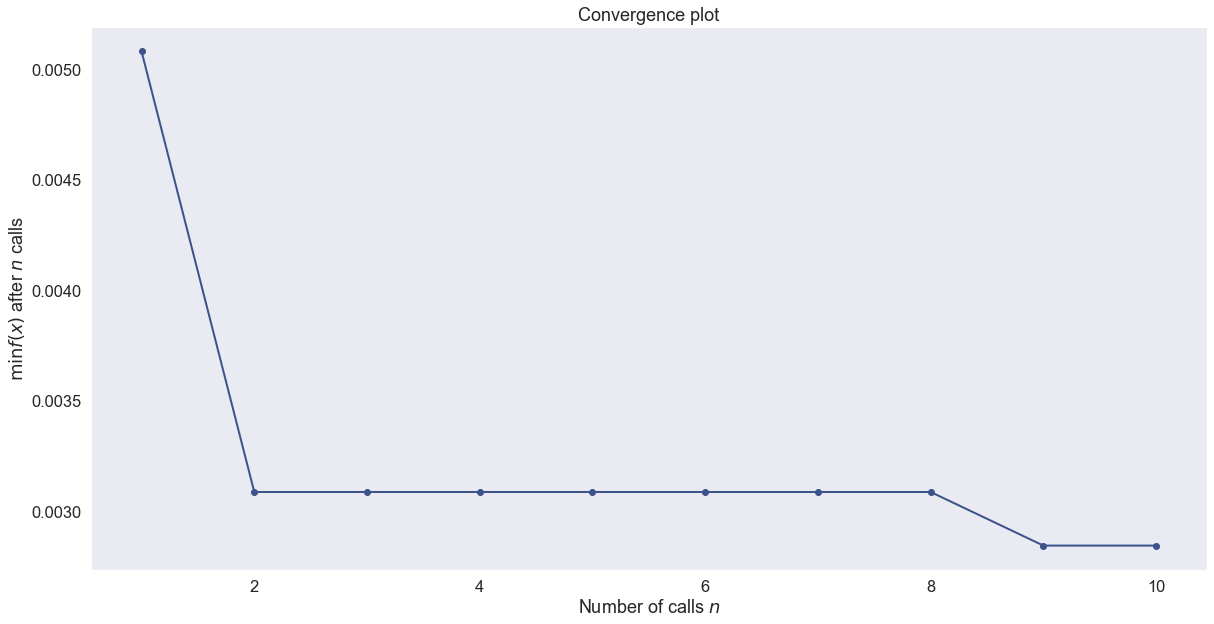

In [35]:
plot_convergence(opt_loaded)

# Model Performance & Evaluation

In [36]:
opt_loaded.x

['poly', 2, 1.9795388574374426, 0.02451675480274238]

In [37]:
regressor = SVR(
    kernel='poly',
    degree=2,
    C=1.9795388574374426,
    epsilon=0.02451675480274238
)

In [38]:
regressor.fit(x_train_full, y_train_full)

SVR(C=1.9795388574374426, degree=2, epsilon=0.02451675480274238, kernel='poly')

In [39]:
predictions = regressor.predict(x_test)

In [40]:
mean_squared_error(predictions, y_test)

0.012592974637280058

In [41]:
r2_score(predictions, y_test)

-2.2822445218539342

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Actual vs Predicted')]

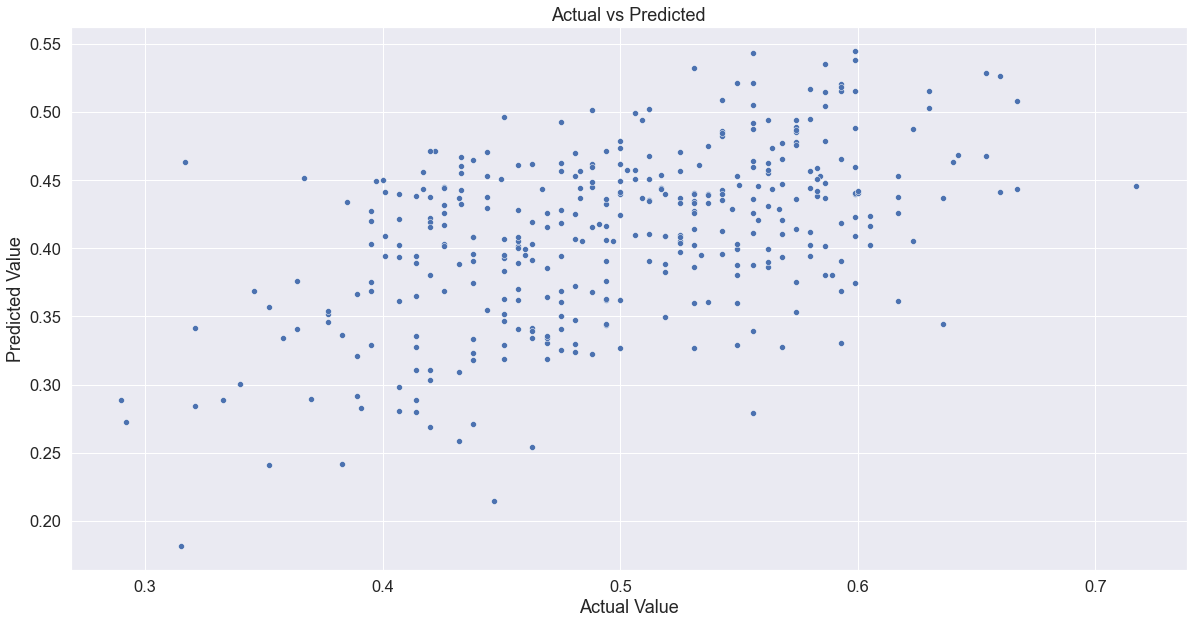

In [42]:
ax = sns.scatterplot(x=y_test, y=predictions)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Actual vs Predicted')

In [43]:
errors = y_test - predictions

[Text(0.5, 0, 'Error'), Text(0.5, 1.0, 'Binned Error Counts')]

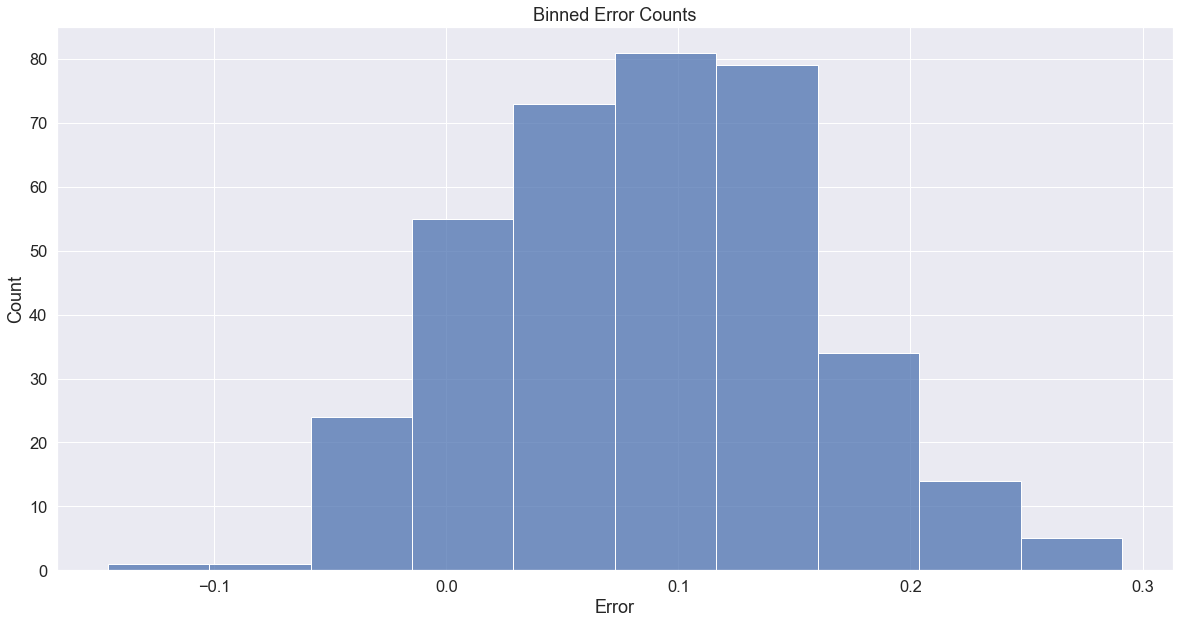

In [44]:
ax = sns.histplot(data=errors, bins=10)
ax.set(xlabel='Error', title='Binned Error Counts')